# Intern Test (round №1)

In [287]:
# Импортируем библиотеки

import sklearn
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder as OHE
from sklearn.linear_model import LinearRegression, Lasso
%matplotlib inline

## Dataset

In [147]:
energydata_complete = pd.read_csv('energydata_complete.csv', header=0, sep=',')
energydata_complete.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


- колонка `date` – временные метки
    - переведите её в тип `datetime`
    - из `date` извлечь *weekofyear* в колонку `week`
    - должны получиться недели со 2 по 21
    - оставить недели 3...20
    - сделать `date` индексом

In [148]:
energydata_complete['date'] = pd.to_datetime(energydata_complete['date'])
energydata_complete['week'] = energydata_complete['date'].dt.week
energydata_complete.shape

<ipython-input-148-a9097c0e67f8>:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  energydata_complete['week'] = energydata_complete['date'].dt.week


(19735, 30)

In [149]:
energydata_complete = energydata_complete[(energydata_complete['week'] != 2) & (energydata_complete['week'] != 21)]

In [150]:
energydata_complete = energydata_complete.sort_values(by='date')
energydata_complete = energydata_complete.set_index('date')

- все остальные колонки воспринимаем как `float`


In [151]:
# Изменим тип остальных колонок на float

for column in energydata_complete.columns:
    if (column != 'date') & (column != 'week'):
        energydata_complete[column] = energydata_complete[column].astype(float)
    else:
        continue

Визуализируйте последнюю неделю 

Text(0, 0.5, 'Appliances')

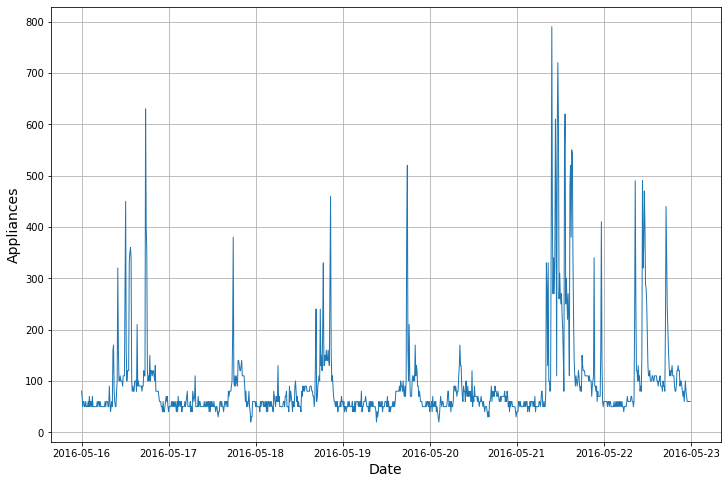

In [152]:
plt.figure(num=None, figsize=(12, 8), facecolor='w', edgecolor='k')
energydata_complete_fig = energydata_complete[energydata_complete['week'] == 20]
plt.plot(energydata_complete_fig.index, energydata_complete_fig['Appliances'], linewidth=1)
plt.grid()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Appliances', fontsize=14)

## Validation

Разобъём датасет на 2 части: 

- данные за недели 19-20 – тестовая выборка
- недели 3-18 – обучающая выборка
- колонка `Appliances` – целевая переменная `y`
- всё остальное – `X`, т.е. признаки

### _Как называется данный вид валидации?_
_Валидация на отложенных выборках (Hold-Out Validation)_

In [153]:

lenght_train = len(energydata_complete[energydata_complete['week'] < 19])

y_train = energydata_complete.iloc[:lenght_train, 0]
X_train = energydata_complete.iloc[:lenght_train, 1:]
y_test = energydata_complete.iloc[lenght_train:, 0]
X_test = energydata_complete.iloc[lenght_train:, 1:]
X_train

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,week
date,,,,,,,,,,,,,,,,,,,,,
2016-01-18 00:00:00,10.0,21.823333,39.900000,20.230000,40.000000,20.323333,39.790000,21.166667,39.863333,19.500000,...,38.400000,-2.800000,763.700000,86.000000,2.000000,25.0,-4.900000,2.995012,2.995012,3
2016-01-18 00:10:00,10.0,21.790000,39.933333,20.166667,40.090000,20.390000,39.790000,21.100000,39.826667,19.390000,...,38.466667,-2.883333,763.583333,86.000000,2.000000,25.5,-4.983333,7.407794,7.407794,3
2016-01-18 00:20:00,10.0,21.730000,40.000000,20.075000,40.067500,20.323333,39.790000,21.100000,39.900000,19.390000,...,38.400000,-2.966667,763.466667,86.000000,2.000000,26.0,-5.066667,3.649394,3.649394,3
2016-01-18 00:30:00,20.0,21.666667,40.000000,20.000000,40.000000,20.290000,39.700000,21.100000,39.933333,19.290000,...,38.466667,-3.050000,763.350000,86.000000,2.000000,26.5,-5.150000,2.144295,2.144295,3
2016-01-18 00:40:00,0.0,21.600000,40.193333,19.945000,40.000000,20.260000,39.760000,21.100000,40.000000,19.290000,...,38.590000,-3.133333,763.233333,86.000000,2.000000,27.0,-5.233333,26.123064,26.123064,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-08 23:10:00,0.0,24.600000,38.400000,23.790000,36.590000,26.290000,37.790000,24.856667,36.060000,23.700000,...,40.790000,16.800000,751.616667,60.333333,2.166667,40.0,9.016667,32.102663,32.102663,18
2016-05-08 23:20:00,0.0,24.566667,38.400000,23.700000,36.730000,26.290000,37.863333,24.790000,36.045000,23.666667,...,40.977143,16.900000,751.633333,59.666667,2.333333,40.0,8.933333,44.412740,44.412740,18
2016-05-08 23:30:00,0.0,24.566667,38.400000,23.700000,36.863333,26.290000,37.900000,24.785000,36.047500,23.600000,...,41.296000,17.000000,751.650000,59.000000,2.500000,40.0,8.850000,24.124543,24.124543,18


### Альтернативное задание

Вместо разбиения на тренировочную и валидационную использовать time-series кросс-валидацию на 5 фолдов

In [154]:
from sklearn.model_selection import TimeSeriesSplit

X_alt = energydata_complete.iloc[:, 1:]
y_alt = energydata_complete.iloc[:, 0]

tscv_index = []

tscv = TimeSeriesSplit()
for train_index, test_index in tscv.split(X_alt.index):    
    tscv_index.append([train_index, test_index])
    print('TRAIN:', train_index, 'TEST:', test_index)

TRAIN: [   0    1    2 ... 3021 3022 3023] TEST: [3024 3025 3026 ... 6045 6046 6047]
TRAIN: [   0    1    2 ... 6045 6046 6047] TEST: [6048 6049 6050 ... 9069 9070 9071]
TRAIN: [   0    1    2 ... 9069 9070 9071] TEST: [ 9072  9073  9074 ... 12093 12094 12095]
TRAIN: [    0     1     2 ... 12093 12094 12095] TEST: [12096 12097 12098 ... 15117 15118 15119]
TRAIN: [    0     1     2 ... 15117 15118 15119] TEST: [15120 15121 15122 ... 18141 18142 18143]


## Feature Extraction
### Gradient Boosting Machine
Обучим градиентный бустинг (выбрать фреймфорк, с которым привыкли работать – CatBoost, XGBoost, LGBM, H2O и т.д.). Возьмём глубину D=4, и количество деревьев N=200, остальные параметры по умолчанию / на ваш выбор.

In [182]:
from xgboost import XGBRegressor, XGBClassifier

clf = XGBRegressor(learning_rate=0.1, max_depth=4, n_estimators=200)

In [183]:
clf.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### _В чём отличие между leaf-wise tree и depth-wise tree?_

_Разница заключается в порядке роста дерева. Большинство алгоритмов используют depth-wise tree. Таким способом деревья растут уровень за уровнем или в глубину (дерево получается симметричным). Алгоритм leaf-wise tree выращивает деревья по листьям. Алгоритм выращивает дерево по листу с наилучшим соответствием. Данный способ позволяет работать эффективнее, чем алгоритмы depth-wise tree._

### Визуализировать feature importances (оставить топ-10) в виде:

Text(0.5, 1.0, 'XGBoost Feature Importance')

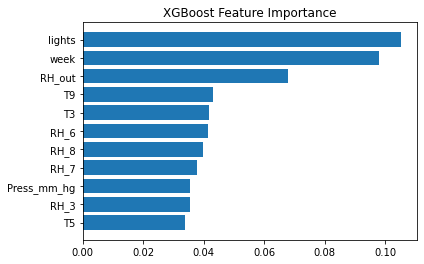

In [184]:
sorted_idx = clf.feature_importances_.argsort()
sorted_idx = sorted_idx[-11:]
plt.barh(X_train.columns[sorted_idx], clf.feature_importances_[sorted_idx])
plt.title("XGBoost Feature Importance")

### _Как считается feature importance в выбранном вами бустинге?_

_Данная мера основана на количестве раз, когда переменная выбирается для разделения. Все значения характеристик отдельных деревьев суммируются, а затем делятся на количество деревьев. Далее происходит проход по дереву, в ходе которого рассчитываются взвешенные частоты узлов, после чего эти взвешанные частоты приписываются характеристикам этих узлов._

Если для валидации выбрана кросс-валидация, мы имеем 5 моделей. У каждой модели своя важность признаков, значит, мы получили некоторое распределение. дополнительно визуализировать его std (черные полоски как на графике ниже)

In [186]:
importances = []

for num in tscv_index:
    max_idx = num[0][-1] + 1
    clf_alt = XGBRegressor(learning_rate=0.1, max_depth=4, n_estimators=200)
    clf_alt.fit(X_alt.iloc[:max_idx,:], y_alt.iloc[:max_idx])
    importances.append(clf_alt.feature_importances_)

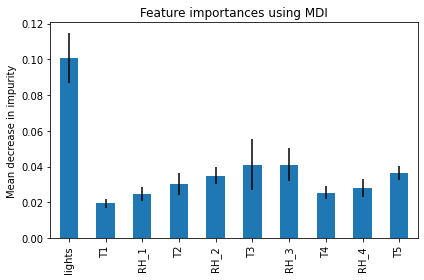

In [187]:
# построим для первых 10 признаков

std = np.std(importances, axis=0)
mean = np.mean(importances, axis=0)
mean_importances = pd.Series(mean, index=X_alt.columns)

mean_importances_1 = mean_importances.iloc[:10]

fig, ax = plt.subplots()
mean_importances_1.plot.bar(yerr=std[:10], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


### *Сколько суммарно листьев у depth-wise tree глубины D? (обозначим ответ за L)*

Не более *$L=2^{D}$* 

### Leafs

Для тренировочной и валидационной части мы сделаем предсказания. Но не в виде прогноза целевой переменной, а в виде перевода в новое признаковое пространство. 

Каждый объект, когда прогоняется через бустинг, попадает в конкретный лист в каждом дереве. Если в каждом дереве L листьев, тогда всего у бустинга (N * L) листьев. Таким образом, объект можно представить как вектор из N индексов, где на i-й позиции номер листа, в который попал объект в i-ом дереве.

Нужно в выбранном фреймворке для бустинга использовать метод, выдающий предсказания в виде индекса листа по каждому дереву

In [278]:
DX_test = xgb.DMatrix(X_test)
DX_train = xgb.DMatrix(X_train)

pred_test = clf.get_booster().predict(DX_test, pred_leaf=True)
pred_train = clf.get_booster().predict(DX_train, pred_leaf=True)

pred_main = np.concatenate((pred_train, pred_test), axis=0)
pred_main.shape

(18144, 200)

Перевести индексы листьев из пространства `[0...L)` (индексы уникальны в рамках дерева) в формат `[0...N*L)` (индексы уникальны в рамках всего ансамбля). 

- допустим мы имеем 3 дерева, объект попал во 2-й лист в первом дереве, в 5-й во втором и в 0-й в третьем.
- на выходе получаем вектор **[2, 5, 0]** (индексы - локальные по каждому дереву)
- его необходимо перевести в **[2, 1*L+5, 2*L+0]** (индексы - глобальные по всему бустингу)
- пример результата на диаграмме

Вывести первые 10 строк и 10 стобцов старой и новой матрицы индексов
(если использована кросс-валидация, по каждому фолду)
+ размерности старой и новой матрицы индексов
+ комментарием в ячейке полученные L и N*L

Предыдущее задание должно быть выполнено с помощью матричной алгебры numpy

In [230]:
max_leaf = 0
for sample in pred_main:
    if max(sample) > max_leaf:
        max_leaf = max(sample)

format_array = np.array([[max_leaf * i for i in range(0,200)]]* len(pred_main))
pred_main_format = pred_main + format_array
print(max_leaf)

30.0


Вывести первые 10 строк и 10 стобцов старой и новой матрицы индексов
(если использована кросс-валидация, по каждому фолду)
+ размерности старой и новой матрицы индексов
+ комментарием в ячейке полученные L и N*L

In [235]:
# L = 30
# N*L = 6000

print(f'Размерность старой матрицы {pred_main.shape}')
print(f'Размерность старой матрицы {pred_main_format.shape}')


print('old matrix')
for sample in pred_main[0:10]:
    print(sample[0:10])

    
print('new matrix') 
for sample in pred_main_format[0:10]:
    print(sample[0:10])

Размерность старой матрицы (18144, 200)
Размерность старой матрицы (18144, 200)
old matrix
[30. 29. 29. 28. 25. 26. 26. 25. 23. 18.]
[30. 29. 29. 28. 25. 26. 26. 25. 23. 18.]
[30. 29. 29. 28. 25. 26. 26. 25. 23. 18.]
[30. 29. 29. 28. 25. 26. 26. 25. 24. 18.]
[20. 21. 20. 22. 20. 20. 21. 21. 23. 18.]
[20. 21. 20. 22. 20. 20. 21. 21. 23. 18.]
[20. 21. 20. 22. 20. 20. 21. 21. 23. 18.]
[20. 21. 20. 22. 20. 20. 21. 21. 23. 18.]
[30. 29. 29. 28. 28. 26. 28. 25. 23. 18.]
[20. 21. 20. 22. 19. 20. 21. 21. 23. 18.]
new matrix
[ 30.  59.  89. 118. 145. 176. 206. 235. 263. 288.]
[ 30.  59.  89. 118. 145. 176. 206. 235. 263. 288.]
[ 30.  59.  89. 118. 145. 176. 206. 235. 263. 288.]
[ 30.  59.  89. 118. 145. 176. 206. 235. 264. 288.]
[ 20.  51.  80. 112. 140. 170. 201. 231. 263. 288.]
[ 20.  51.  80. 112. 140. 170. 201. 231. 263. 288.]
[ 20.  51.  80. 112. 140. 170. 201. 231. 263. 288.]
[ 20.  51.  80. 112. 140. 170. 201. 231. 263. 288.]
[ 30.  59.  89. 118. 148. 176. 208. 235. 263. 288.]
[ 20.  51.

**One-Hot Encoding**

Имея глобальные индексы листьев, можем перевести их в пространство нулей и единиц:

- пусть на предыдущем шаге мы получили индексы [1, 4, 7), а всего индексов 8
- перевести их в формат [0, 1, 0, 0, 1, 0, 0, 1]

Это и будет новым признаковым пространством, в которое мы перевели датасет с помощью градиентного бустинга

In [280]:
ntrees = 200
L = 30

ohe_data = np.zeros((len(pred_main_format), ntrees * L))
for row in range(len(pred_main_format)):
    for idx in pred_main_format[row]:
        ohe_data[row][int(idx)-1] = 1
ohe_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

## D. Linear Regression

**LinReg**

поверх полученной матрицы из нулей и единиц обучаем линейную регрессию

добавить L1 регуляризацию, λ=0.666

In [283]:
X_train_ohe = ohe_data[:len(X_train)]
X_test_ohe = ohe_data[len(X_train):]

(16128, 6000)

In [285]:
model = LinearRegression()
model.fit(X_train_ohe, y_train)

LinearRegression()

In [289]:
model_l1 = Lasso(alpha=0.666)
model_l1.fit(X_train_ohe, y_train)

Lasso(alpha=0.666)

In [296]:
len(model_l1.coef_)

6000

In [304]:
i = 0
for idx in range(len(model_l1.coef_)):
    if model.coef_[idx] == model_l1.coef_[idx]:
        continue
    elif (model.coef_[idx] != 0) & (model_l1.coef_[idx] == 0):
        i += 1
    else:
        continue

print(f'Отключилось {round(i * 100 / 6000)} % признаков')


Отключилось 61 % признаков


**В чём разница между L1 и L2 регуляризацией? почему L1 можно использовать для отбора признаков, а L2 нельзя?**

L1 регуляризация не является гладкой в геометрическом смысле. Из-за своей угловатости модель имеет свойства находить пересечения некоторых признаков с осью какого-либо признака, что означает, что некоторые признаки в данной точке будут равны 0. Геометрическим смыслом L2-регуляризации является поиск в некоторой округлой области с центром в 0. Если посмотреть на аналитический смысл L2 регуляризации, то можно понять, что L2 регуляризация уменьшает большие веса, и при этом не трогает маленькие, следовательно обнулить какие-либо веса не получится. Так как данный регуляризатор работает с нормой, которая будет становиться меньше, если вычитать из большего веса определенную величину, то значение будет уменьшаться больше, если вычитать из большего параметра ветора весов. В L1 регуляризации не важно из какого веса вычитать некоторое значение. поэтому некоторые веса в модели обнуляются, что приводит к уменьшению значения регуляризатора (не факт, что модель улучшиться).

Визуализировать реальный таргет и его прогноз (последние 100 точек, сортировка по дате). если использована кросс-валидация, то по график нужен для каждого фолда

In [307]:
y_predict_l1 = model_l1.predict(X_test_ohe)
y_predict_l1.shape

(2016,)

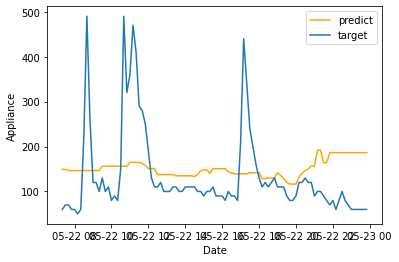

In [336]:
plt.plot(energydata_complete.index[-100:], y_predict_l1[-100:], color='orange', label='predict')
plt.plot(energydata_complete.index[-100:], y_test[-100:], label='target')
plt.xlabel('Date')
plt.ylabel('Appliance')
plt.legend(loc='best')

**Confidence Bound**

 На веса модели (исключая bias) накинуть случайный шум 10000 раз.
например, $w' = w \tau,\ \tau \sim \mathcal{N}(1,\ 0.2)$


In [332]:
coefficients = model_l1.coef_
idx = 0
for idx in range(10000):
    coefficients += np.random.normal(1, 0.2, 6000)
    idx +=1

**Какие квантили отвечают за нижнюю и верхнюю границу 95%-го доверительного интервала? (LCB и UCB)**

В случае нормального распределения квантиль нижняя граница -1.645, а верхняя 1.645